# Hyperparameter optimization for machine learning

Many machine learning models have hyperparamters -- parameters that control some aspect of the model. The exact setting of these hyperparameters can dramatically impact the performance of your underlying model. Fortunately, most hyperparameters can be tried in parallel, making the task of *hyperparemter optimization* a great fit for PyWren. 

Here we use a simple dataset included in scikit-learn to show how to do hyperparameter optimization across a number of different datasets, and a number of different cross-validations 

In [5]:
%pylab inline
import pywren
import sklearn
import seaborn as sns
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.svm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline


Populating the interactive namespace from numpy and matplotlib


In [3]:
# load the dataset from scikit learn
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

First we explore generic prediction on the dataset with an off-the-shelf classifier

In [6]:

# load the data as X and y
X = bc['data']
y = bc['target']

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=0)

# construct a scikit learn pipeline which normalizes
# the data and then runs a SVM 

p = Pipeline(steps=[('standardize', StandardScaler()), 
                    ('learn', sklearn.svm.SVC(C=0.1, kernel='poly', degree=3))])


# fit the data
p.fit(X_train, y_train)

# predict the held-out data
pred = p.predict(X_test)

# measure the accuracy
sklearn.metrics.accuracy_score(y_test, pred)

0.81578947368421051

# use PyWren to try many HP values
Now we try for many folds and many hyperparameters with pywren

In [7]:
# now we can train lots of models! and get error bars! 

def train_model(args):
    """
    
    """
    # extract the args
    (X_train, X_test, y_train, y_test), hps = args
    
    import sklearn.svm 
    
    # create the pipeline
    p = Pipeline(steps=[('standardize', StandardScaler()), 
                        ('learn', sklearn.svm.SVC(**hps))])
    
    # fit
    p.fit(X_train, y_train)
    return p


wrenexec = pywren.default_executor()


FOLD_N = 10 # number of cross-validation sets

cv_sets = []
for i in range(FOLD_N):
    cv_sets.append(train_test_split(
                     X, y, test_size=0.4, random_state=i))

# set of SVM hyperparameters we want to try
hps =  [dict(C=10.0, kernel='rbf', degree=3), 
        dict(C=1.0, kernel='rbf', degree=3),
        dict(C=0.1, kernel='rbf', degree=3)]


# combine them all using itertools
args = list(itertools.product(cv_sets, hps) )


In [8]:
# perform the map                   
futures = wrenexec.map(train_model, args)
results = pywren.get_all_results(futures)

# Getting the results

We construct a dataframe of the results to facilitate subsequent analysis

In [9]:
# construct a dataframe using the resulting models to predict accuracy on their held-out dataset
res = []
for m, ((X_train, X_test, y_train, y_test), hps) in zip(results, args):
    pred = m.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, pred)
    hp_row = hps.copy()
    hp_row['accuracy'] = acc
    res.append(hp_row)
df = pd.DataFrame(res)

### we use seaborn to plot the results

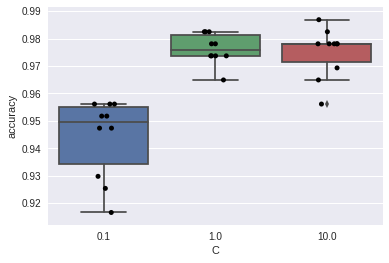

In [10]:
sns.boxplot(x='C', y='accuracy', data=df)
sns.stripplot(x='C', y='accuracy', data=df, color='k', jitter=True)
